### Pneumonia Detection Model Classification ###


* Image compression and It's Coordinates behaviour

* Kfold Cross validation on CNN model

* Hyper parameters on CNN sequential model

* CNN with Tranfer learning using VGG16 

* Pretrained model - DenseNet121 

* Analysis on Reasearch Papers as part of Capstone project, VGG19 and RESNET50


In [5]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [6]:
# IMPORT PACKAGES
import warnings; warnings.filterwarnings('ignore')

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import os, zipfile, random, csv
import seaborn as sns
import pydicom as dcm
from glob import glob
import cv2

%matplotlib inline

# SET VARIABLES
PATH = 'C:\Janardhana_ArtificalIntelligence\Janardhana_Work_AI\Capstone_Project'
os.chdir(PATH)

DATA_DIR = os.path.join(PATH + '\Project_Statement_DataSet')
TRAIN_IMAGES = os.path.join(DATA_DIR + '\stage_2_train_images')
TEST_IMAGES = os.path.join(DATA_DIR + '\stage_2_test_images')
OUTPUT_DIR = os.path.join(PATH + '\output')

if not os.path.exists(DATA_DIR): os.makedirs(DATA_DIR)
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)
os.environ['KAGGLE_CONFIG_DIR'] = DATA_DIR

# CUSTOM MODULES
#from module.eda import *
#from module.visualize import *

# SET RANDOM SEED
np.random.seed(2018)

In [ ]:
## Exploratory Data Analysis (EDA)

Here as a part of EDA, we will:
* Start with understanding of the data with a brief on train/test labels and respective class info
* Look at the first five rows of both the csvs (train and test)
* Identify how are classes and target distributed
* Check the number of patients with 1, 2, ... bounding boxes
* Read and extract metadata from dicom files
* Perform analysis on some of the features from dicom files
* Check some random images from the training dataset
* Draw insights from the data at various stages of EDA

In [ ]:
### Reading CSVs
* Images for the current stage in the `stage_2_train_images` and `stage_2_test_images`.
* Training data: `stage_2_train_labels.csv`
* `stage_2_detailed_class_info.csv` containing detailed information about the positive and negative classes in the training set

In [7]:
DATA_DIR = 'C:\Janardhana_ArtificalIntelligence\Janardhana_Work_AI\Capstone_Project\Project_Statement_DataSet'
print('--'*15, 'Reading Datasets (two csv files)', '--'*15)
train_labels = pd.read_csv(DATA_DIR + '\stage_2_train_labels.csv')
class_info = pd.read_csv(DATA_DIR +'\stage_2_detailed_class_info.csv')

print(f'Train Labels dataframe has {train_labels.shape[0]} rows and {train_labels.shape[1]} columns')
print(f'Class info dataframe has {class_info.shape[0]} rows and {class_info.shape[1]} columns')
print('Number of duplicates in patientID in train labels dataframe: {}'.format(len(train_labels) - (train_labels['patientId'].nunique())))
print('Number of duplicates in patientID in class info dataframe: {}'.format(len(class_info) - (class_info['patientId'].nunique())))

------------------------------ Reading Datasets (two csv files) ------------------------------
Train Labels dataframe has 30227 rows and 6 columns
Class info dataframe has 30227 rows and 2 columns
Number of duplicates in patientID in train labels dataframe: 3543
Number of duplicates in patientID in class info dataframe: 3543


In [8]:
print('--'*10, 'First five rows of both dataframes (train_labels, class_info)', '--'*10)
print('Train labels dataframe:\n'); display(train_labels.head())
print('\nClass info dataframe:\n'); display(class_info.head())

-------------------- First five rows of both dataframes (train_labels, class_info) --------------------
Train labels dataframe:



,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1



Class info dataframe:



,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [9]:
print('Numbers of nulls in bounding boxes columns are equal to the 0s we\'ve in Target column'); print('--'*40)
print('Checking nulls in bounding boxes columns: {}'.format(train_labels[['x', 'y', 'width', 'height']].isnull().sum().to_dict())) 
print('Checking value counts for the targets: {}'.format(train_labels['Target'].value_counts().to_dict()))

Numbers of nulls in bounding boxes columns are equal to the 0s we've in Target column
--------------------------------------------------------------------------------
Checking nulls in bounding boxes columns: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}
Checking value counts for the targets: {0: 20672, 1: 9555}


Lets check the distribution of `Target` and `class` column
--------------------------------------------------------------------------------


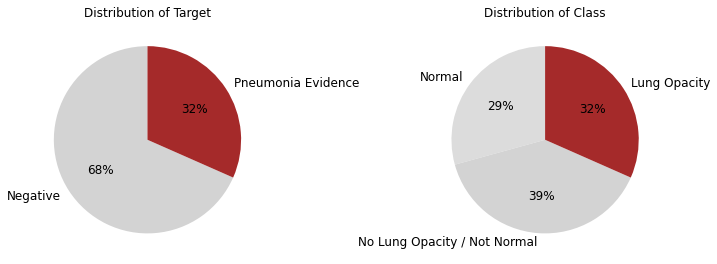

In [10]:
print('Lets check the distribution of `Target` and `class` column'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_labels['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['Negative', 'Pneumonia Evidence'], 
          colors = ['lightgray', 'brown'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (class_info['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['gainsboro', 'lightgray', 'brown'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 12)
    .set_ylabel(''))
plt.tight_layout()

In [11]:
print('Let\'s group by patient IDs and check number of bounding boxes for each unique patient ID');print('--'*40)
bboxes = train_labels.groupby('patientId').size().to_frame('number_of_boxes').reset_index()
train_labels = train_labels.merge(bboxes, on = 'patientId', how = 'left')
print('Number of unique patient IDs in the dataset: {}'.format(len(bboxes)))
print('\nNumber of patientIDs per bboxes in the dataset')
(bboxes.groupby('number_of_boxes')
.size()
.to_frame('number_of_patientIDs_per_boxes')
.reset_index()
.set_index('number_of_boxes')
.sort_values(by = 'number_of_boxes'))

Let's group by patient IDs and check number of bounding boxes for each unique patient ID
--------------------------------------------------------------------------------
Number of unique patient IDs in the dataset: 26684

Number of patientIDs per bboxes in the dataset


,number_of_patientIDs_per_boxes
number_of_boxes,
1,23286
2,3266
3,119
4,13


In [12]:
print('Let\'s also check whether each patientId has only one type of class'); print('--'*40)
print('Yes, each patientId is associated with only {} class'.format(class_info.groupby(['patientId'])['class'].nunique().max()))

# Merge the two dataframes
train_class = pd.concat([train_labels, class_info['class']], axis = 1)
print('Shape of the dataset after the merge: {}'.format(train_class.shape))

Let's also check whether each patientId has only one type of class
--------------------------------------------------------------------------------
Yes, each patientId is associated with only 1 class
Shape of the dataset after the merge: (30227, 8)


In [13]:
train_class.head()

,patientId,x,y,width,height,Target,number_of_boxes,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity


In [14]:
### Missing data
Let's check missing information in the two datasets.

SyntaxError: EOL while scanning string literal (1961968084.py, line 2)

In [15]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))
missing_data(train_labels)

,x,y,width,height,patientId,Target,number_of_boxes
Total,20672.000000,20672.000000,20672.000000,20672.000000,0.0,0.0,0.0
Percent,68.389188,68.389188,68.389188,68.389188,0.0,0.0,0.0


In [16]:
missing_data(class_info)

,patientId,class
Total,0.0,0.0
Percent,0.0,0.0


In [ ]:
The percent missing for x,y, height and width in train labels represents the percent of the target 0 (not Lung opacity).

Let's check the class distribution from class detailed info.

In [ ]:
#### Observations from the CSVs
Based on analysis above, some of the observations:

* Training data is having a set of patientIds and bounding boxes. Bounding boxes are defined as follows: x, y, width and height.
* There are multiple records for patients. Number of duplicates in patientID = 3,543.
* There is also a binary target column i.e. Target indicating there was evidence of pneumonia or no definitive evidence of pneumonia.
* Class label contains: No Lung Opacity/Not Normal, Normal and Lung Opacity.
* Chest examinations with Target = 1 i.e. ones with evidence of Pneumonia are associated with Lung Opacity class.
* Chest examinations with Target = 0 i.e. those with no definitive effidence of Pneumonia are either of Normal or No Lung Opacity / Not Normal class.
* About 23,286 patientIds (~87% of them) provided have 1 bounding boxes while 13 patients have 4 bounding boxes!!!!

In [ ]:
### Reading Images
Images provided are stored in DICOM (.dcm) format which is an international standard to transmit, store, retrieve, print, process, and display medical imaging information. 
Digital Imaging and Communications in Medicine (DICOM) makes medical imaging information interoperable. 
We will make use of pydicom package here to read the images. 

In [17]:
sample_patient_id = train_labels['patientId'][0]
dcm_file = TRAIN_IMAGES + '\{}.dcm'.format(sample_patient_id)
dcm_data = dcm.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
#### Observations from dicom image files
From the above sample we can see that dicom file contains some of the information that can be used for further analysis such as sex, age, body part examined (which should be mostly chest), view position and modality. 
Size of this image is 1024 x 1024 (rows x columns).

In [ ]:
### Feature extraction from the dicom image files
Above we identified some features from the dicom files that can explored/used, let's focus on the following analysis from the image files
* To understand distribution of age for those with evidence of lung opacity and those with no definite evidence of lung opacity.
* To understand distribution of male and female for those with evidence of lung opacity and those with no definite evidence of lung opacity
* Explore different view positions in the dataset
* Explore modallity

To get the features from dicom image files, we will make use of function (`get_tags`) defined in (`eda`).

In [18]:
print('Read the training images file names and path'); print('--'*40)
images = pd.DataFrame({'path': glob(os.path.join(TRAIN_IMAGES, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print('Number of images in the training folder: {}'.format(images.shape[0]))
print('Columns in the training images dataframe: {}'.format(list(images.columns)))
assert images.shape[0] == len(list(set(train_class['patientId']))), 'Number of training images should be equal to the unique patientIds we have'

Read the training images file names and path
--------------------------------------------------------------------------------
Number of images in the training folder: 26684
Columns in the training images dataframe: ['path', 'patientId']


In [19]:
print('Merge path from the `images` dataframe with `train_class` dataframe'); print('--'*40)
train_class = train_class.merge(images, on = 'patientId', how = 'left')
print('Shape of the `train_class` dataframe after merge: {}'.format(train_class.shape))
del images

Merge path from the `images` dataframe with `train_class` dataframe
--------------------------------------------------------------------------------
Shape of the `train_class` dataframe after merge: (30227, 9)


In [20]:
# CUSTOM MODULES
import eda
import edaviz

In [21]:
def get_tags(data, path):
    images = os.listdir(path)
    for _, name in tqdm_notebook(enumerate(images)):
        img_path = os.path.join(path, name)
        img_data = dcm.read_file(img_path)
        idx = (data['patientId'] == img_data.PatientID)
        data.loc[idx,'PatientSex'] = img_data.PatientSex
        data.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        data.loc[idx,'BodyPartExamined'] = img_data.BodyPartExamined
        data.loc[idx,'ViewPosition'] = img_data.ViewPosition
        data.loc[idx,'Modality'] = img_data.Modality

In [22]:
print('Get features such as {} from training images'.format(('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality')))
get_tags(train_class, TRAIN_IMAGES)

print('Saving the feature engineered dataframe for future use'); print('--'*40)
train_class.to_pickle('./output/train_feature_engineered.pkl')

Get features such as ('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality') from training images


0it [00:00, ?it/s]

Saving the feature engineered dataframe for future use
--------------------------------------------------------------------------------


In [23]:
train_class = pd.read_pickle('./output/train_feature_engineered.pkl')
train_class.shape

(30227, 14)

In [24]:
train_class.head()

,patientId,x,y,width,height,Target,number_of_boxes,class,path,PatientSex,PatientAge,BodyPartExamined,ViewPosition,Modality
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,C:\Janardhana_ArtificalIntelligence\Janardhana...,F,51.0,CHEST,PA,CR
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,C:\Janardhana_ArtificalIntelligence\Janardhana...,F,48.0,CHEST,PA,CR
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,C:\Janardhana_ArtificalIntelligence\Janardhana...,M,19.0,CHEST,AP,CR
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,C:\Janardhana_ArtificalIntelligence\Janardhana...,M,28.0,CHEST,PA,CR
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,C:\Janardhana_ArtificalIntelligence\Janardhana...,F,32.0,CHEST,AP,CR


In [25]:
print('As expected unique in `BodyPartExamined` is: {}'.format(train_class['BodyPartExamined'].unique()[0]))
print('Unique in `Modality` is: {}'.format(train_class['Modality'].unique()[0])); print('--'*40)

As expected unique in `BodyPartExamined` is: CHEST
Unique in `Modality` is: CR
--------------------------------------------------------------------------------


In [26]:
train_class.drop('BodyPartExamined', inplace=True, axis=1)
train_class.drop('Modality', inplace=True, axis=1)

In [27]:
#### Understanding different View Positions
As seen below, two View Positions that are in the training dataset are AP (Anterior/Posterior) and PA (Posterior/Anterior). These type of X-rays are mostly used to obtain the front-view. Apart from front-view, a lateral image is usually taken to complement the front-view.

* **Posterior/Anterior (PA)**: In PA, X-Ray beam hits the posterior (back) part of the chest before the anterior (front) part. While obtaining the image patient is asked to stand with their chest against the film.
* **Anterior/Posterior (AP)**: At times it's not possible for radiographers to acquire a PA chest X-ray. This is usually because the patient is too unwell to stand. AP projection images are of lower quality than PA images. Heart size is exaggerated (cardiothoracic ratio approximately 50%)


SyntaxError: invalid syntax (1403817831.py, line 2)

Get the distribution of `ViewPosition` overall and where Target = 1
Overall the distribution is almost equal for `ViewPosition` but where there's a Pneumonia Evidence, `ViewPosition` is `AP`
AP: Anterior/Posterior, PA: Posterior/Anterior
--------------------------------------------------------------------------------


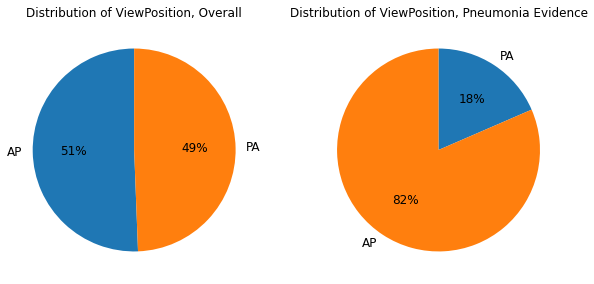

In [28]:
print('Get the distribution of `ViewPosition` overall and where Target = 1')
print('Overall the distribution is almost equal for `ViewPosition` but where there\'s a Pneumonia Evidence, `ViewPosition` is `AP`')
print('AP: Anterior/Posterior, PA: Posterior/Anterior'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_class['ViewPosition'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%',  
          startangle = 90,
          title = 'Distribution of ViewPosition, Overall', 
          fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (train_class.loc[train_class['Target'] == 1, 'ViewPosition']
     .value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          startangle = 90, counterclock = False, 
          title = 'Distribution of ViewPosition, Pneumonia Evidence', 
          fontsize = 12)
    .set_ylabel(''))

In [ ]:
Exploring the bounding boxes for both view positions
* Centers of the rectangle would be x+width/2 and y+height/2 as also described in the reference link [*(source)*](https://stackoverflow.com/questions/32471199/why-is-the-center-of-a-rectangle-xwidth-2-yheight-2-in-java).
* We will make use of (`bboxes_scatter`) function in the (`eda`).
Reference for these plots and function [*(source)*](https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda).

Plot x and y centers of bounding boxes
--------------------------------------------------------------------------------


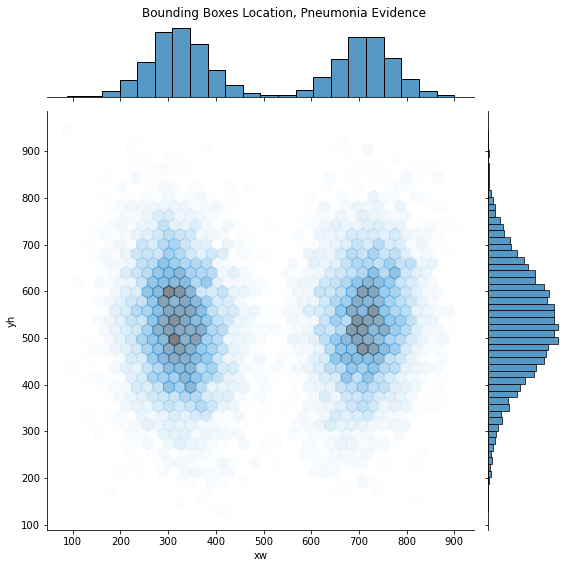

In [29]:
print('Plot x and y centers of bounding boxes'); print('--'*40)
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class[train_class['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

g = sns.jointplot(x = bboxes['xw'], y = bboxes['yh'], data = bboxes, 
                  kind = 'hex', alpha = 0.5, size = 8)
plt.suptitle('Bounding Boxes Location, Pneumonia Evidence')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.show()

In [30]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import os



def bboxes_scatter(df1, df2, text1, text2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 8))
    fig.subplots_adjust(top = 0.85)
    fig.suptitle('Plotting centers of lung opacity\n{} & {}'.format(text1, text2))
    df1.plot.scatter(x = 'xw', y = 'yh', ax = ax1, alpha = 0.8, marker = '.', 
                   xlim = (0, 1024), ylim = (0, 1024), color = 'green')
    ax1.set_title('Centers of Lung Opacity\n{}'.format(text1))
    for i, row in df1.iterrows():
        ax1.add_patch(Rectangle(xy = (row['x'], row['y']),
                            width = row['width'], height = row['height'], 
                            alpha = 3.5e-3, color = 'yellow'))
    plt.title('Centers of Lung Opacity\n{}'.format(text2))
    df2.plot.scatter(x = 'xw', y = 'yh', ax = ax2, alpha = 0.8, marker = '.',
                   color = 'brown',  xlim = (0, 1024), ylim = (0, 1024))
    ax2.set_title('Centers of Lung Opacity\n{}'.format(text2))
    for i, row in df2.iterrows():
        ax2.add_patch(Rectangle(xy = (row['x'], row['y']),
                             width = row['width'], height = row['height'],
                             alpha = 3.5e-3, 
                             color = 'yellow'))
    plt.show()

Exploring the bounding boxes centers for `ViewPositions` for random sample = 1000


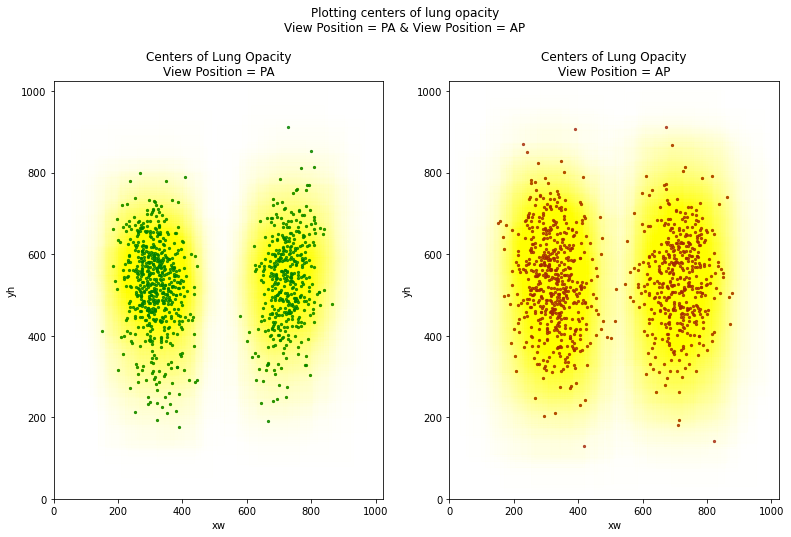

In [31]:
print('Exploring the bounding boxes centers for `ViewPositions` for random sample = 1000')

df1 = bboxes[bboxes['ViewPosition'] == 'PA'].sample(1000)
df2 = bboxes[bboxes['ViewPosition'] == 'AP'].sample(1000)
bboxes_scatter(df1, df2, 'View Position = PA', 'View Position = AP')

In [ ]:
#### Observations: BodyPartExamined & ViewPosition
Above we saw,
* `BodyPartExamined` is unique for all cases and is CHEST in the training dataset and that was also expected.
* Unique in `Modality` is CR i.e. Computer Radiography
* Overall `ViewPosition` is almost equally distributed in the training dataset but for cases where `Target=1`, most of the view position are `AP`.

Checking outliers in `PatientAge
--------------------------------------------------------------------------------
Minimum `PatientAge` in the training dataset: 1.0
Maximum `PatientAge` in the training dataset: 155.0
75th Percentile of `PatientAge` in the training dataset: 59.0
`PatientAge` in upper whisker for box plot: 84.0



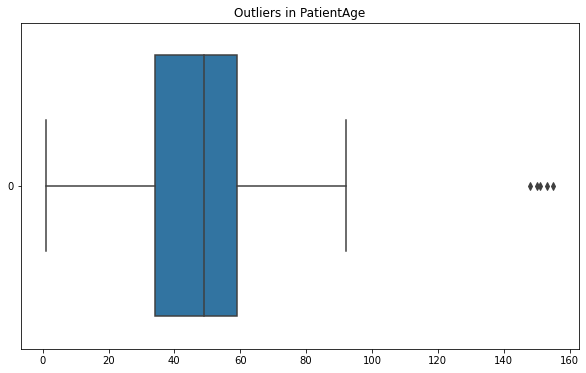

In [32]:
print('Checking outliers in `PatientAge'); print('--'*40)
print('Minimum `PatientAge` in the training dataset: {}'.format(train_class['PatientAge'].min()))
print('Maximum `PatientAge` in the training dataset: {}'.format(train_class['PatientAge'].max()))
print('75th Percentile of `PatientAge` in the training dataset: {}'.format(train_class['PatientAge'].quantile(0.75)))
print('`PatientAge` in upper whisker for box plot: {}'.format(train_class['PatientAge'].quantile(0.75) + (train_class['PatientAge'].quantile(0.75) - train_class['PatientAge'].quantile(0.25))))
print()
fig = plt.figure(figsize = (10, 6))
ax = sns.boxplot(data = train_class['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

We can make use of `pd.clip()` to trim value to a specified lower and upper threshold.
So an upper threshold of 100 in PatientAge would mean those outlier values being converted to 100.

In [34]:
print('Using pd.clip to set upper threshold of 100 for age and remove outliers'); print('--'*40)
train_class['PatientAge'] = train_class['PatientAge'].clip(train_class['PatientAge'].min(), 100)
train_class['PatientAge'].describe().astype(int)

Using pd.clip to set upper threshold of 100 for age and remove outliers
--------------------------------------------------------------------------------


count    30227
mean        46
std         16
min          1
25%         34
50%         49
75%         59
max        100
Name: PatientAge, dtype: int32

Get the distribution of `PatientAge` overall and where Target = 1
--------------------------------------------------------------------------------


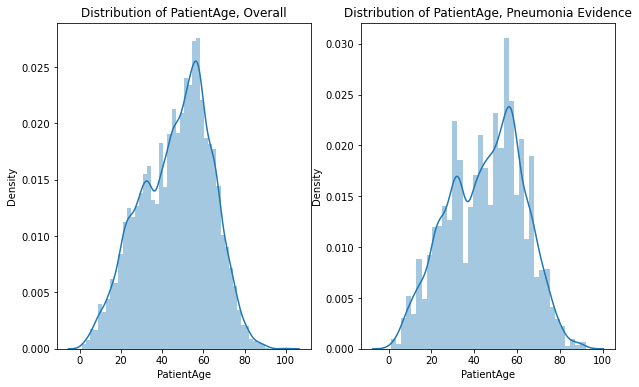

In [35]:
print('Get the distribution of `PatientAge` overall and where Target = 1'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (sns.distplot(train_class['PatientAge'])
    .set_title('Distribution of PatientAge, Overall'))
ax = fig.add_subplot(122)
g = (sns.distplot(train_class.loc[train_class['Target'] == 1, 'PatientAge'])
    .set_title('Distribution of PatientAge, Pneumonia Evidence'))

**Using Binning Method for `PatientAge` feature**

We'll make use of a `pd.cut` which is *'Bin values into discrete intervals'*. 
Use of this method is recommended when need is to segment and sort data values into bins.
This function is also useful for going from a continuous variable to a categorical variable. 
Supports binning into an equal number of bins, or a pre-specified array of bins.

In [36]:
print('Creating Age Binning field', '--'*40)
train_class['AgeBins'] = pd.cut(train_class['PatientAge'], bins = 4, precision = 0, labels = ['<=26', '<=50', '<=75', '<=100'])
train_class['AgeBins'].value_counts()

Creating Age Binning field --------------------------------------------------------------------------------


<=75     13318
<=50     12157
<=26      3972
<=100      780
Name: AgeBins, dtype: int64

Value counts of the age bin field created
--------------------------------------------------------------------------------


,"Counts of Age Bins, Overall","Counts of Age Bins, Target=1"
<=26,3972,1478
<=50,12157,3917
<=75,13318,3895
<=100,780,265


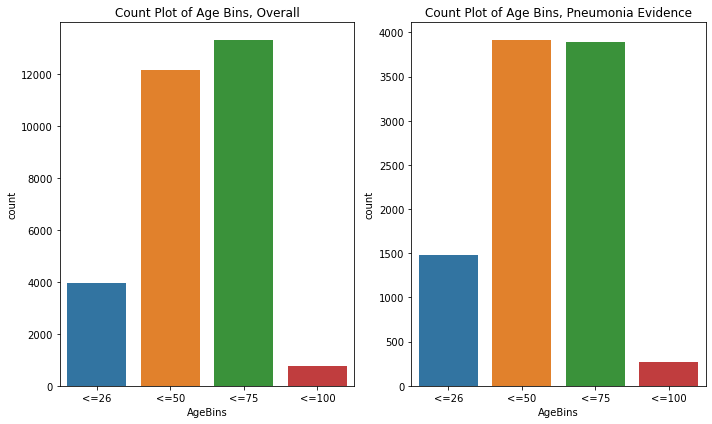

In [37]:
print('Value counts of the age bin field created'); print('--'*40)
display(pd.concat([train_class['AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Overall'), 
                   train_class.loc[train_class['Target'] == 1, 'AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Target=1')], axis = 1))
print()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
g = sns.countplot(x = train_class['AgeBins'], ax = ax1).set_title('Count Plot of Age Bins, Overall')
g = sns.countplot(x = train_class.loc[train_class['Target'] == 1, 'AgeBins'], ax = ax2).set_title('Count Plot of Age Bins, Pneumonia Evidence')
plt.tight_layout()

Exploring the bounding boxes centers for `AgeBins` for random sample = 200


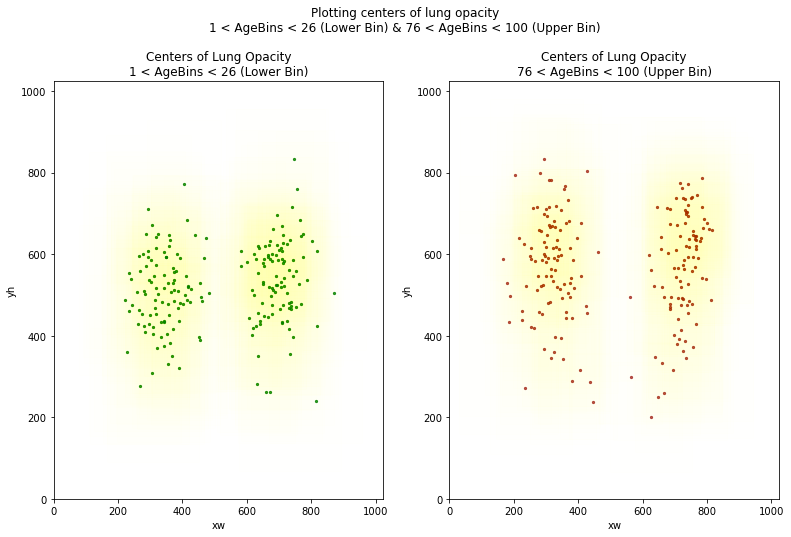

In [38]:
print('Exploring the bounding boxes centers for `AgeBins` for random sample = 200')
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class[train_class['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

df1 = bboxes[bboxes['AgeBins'] == '<=26'].sample(200)
df2 = bboxes[bboxes['AgeBins'] == '<=100'].sample(200)
bboxes_scatter(df1, df2, '1 < AgeBins < 26 (Lower Bin)', '76 < AgeBins < 100 (Upper Bin)')

Checking distribution of age for those with Pneumonia Evidence, by Gender & Count Plot of Gender
--------------------------------------------------------------------------------


,"% Gender, Overall","% Gender, Target=1"
F,0.43,0.42
M,0.57,0.58


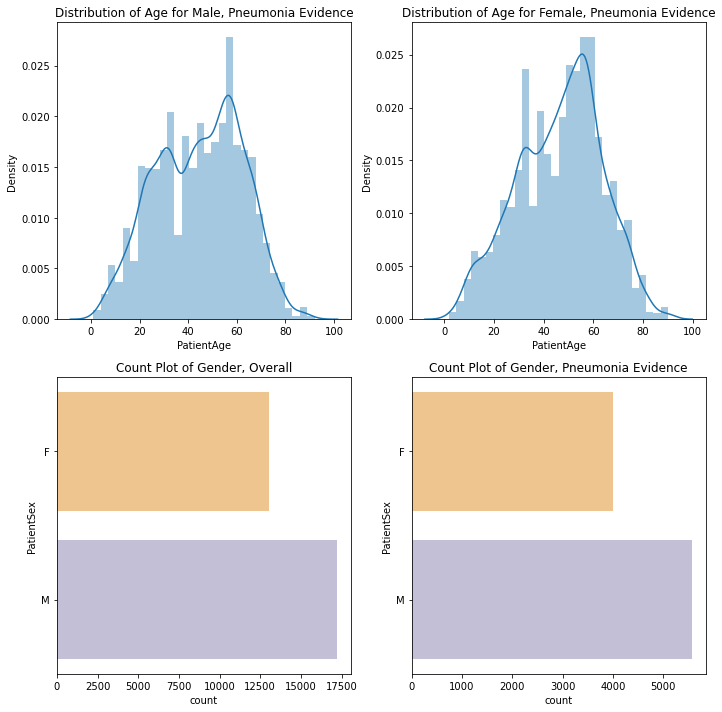

In [39]:
print('Checking distribution of age for those with Pneumonia Evidence, by Gender & Count Plot of Gender'); print('--'*40)
display(pd.concat([train_class['PatientSex'].value_counts(normalize = True).round(2).sort_values().rename('% Gender, Overall'), 
                   train_class.loc[(train_class['Target'] == 1), 'PatientSex']
                   .value_counts(normalize = True).round(2).sort_index().rename('% Gender, Target=1')], axis = 1))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
g = sns.distplot(train_class.loc[(train_class['Target'] == 1) & (train_class['PatientSex'] == 'M'), 'PatientAge'], ax = ax1).set_title('Distribution of Age for Male, Pneumonia Evidence')
g = sns.distplot(train_class.loc[(train_class['Target'] == 1) & (train_class['PatientSex'] == 'F'), 'PatientAge'], ax = ax2).set_title('Distribution of Age for Female, Pneumonia Evidence')
g = sns.countplot(y = train_class['PatientSex'], ax = ax3, palette = 'PuOr').set_title('Count Plot of Gender, Overall')
g = sns.countplot(y = train_class.loc[(train_class['Target'] == 1), 'PatientSex'], ax = ax4, palette = 'PuOr').set_title('Count Plot of Gender, Pneumonia Evidence')
plt.tight_layout()

Exploring the bounding boxes centers for `PatientSex` for random sample = 1000


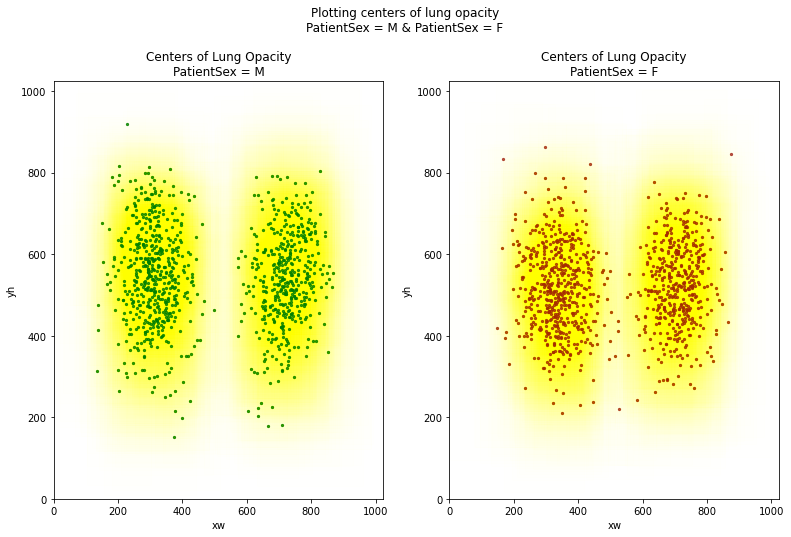

In [40]:
print('Exploring the bounding boxes centers for `PatientSex` for random sample = 1000')
df1 = bboxes[bboxes['PatientSex'] == 'M'].sample(1000)
df2 = bboxes[bboxes['PatientSex'] == 'F'].sample(1000)
bboxes_scatter(df1, df2, 'PatientSex = M', 'PatientSex = F')

In [ ]:
#### Observations: PatientAge & PatientSex
Above we saw,
* For `PatientAge` we saw the distribution for both overall and where there were evidence of Pneumonia. Used binning to check the count of age bins. Count was highest for age group 40-78 both overall and with Pneumonia Evidence. 
* Saw distribution of age for Male and Female with Pneumonia Evidence.
* Dataset had more Males (57%-58%) than Females (42%-43%).

>Only `PatientAge`, `PatientSex` and `ViewPosition` are useful features from metadata.

Dropping the other features from `train_class` dataframe and save that as a pickle file 

In [41]:
train_class.drop(['AgeBins'], inplace = True, axis = 1)
train_class.to_pickle('./output/train_class_features.pkl')
display(train_class.shape, train_class.head())

(30227, 12)

,patientId,x,y,width,height,Target,number_of_boxes,class,path,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,C:\Janardhana_ArtificalIntelligence\Janardhana...,F,51.0,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,C:\Janardhana_ArtificalIntelligence\Janardhana...,F,48.0,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,C:\Janardhana_ArtificalIntelligence\Janardhana...,M,19.0,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,C:\Janardhana_ArtificalIntelligence\Janardhana...,M,28.0,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,C:\Janardhana_ArtificalIntelligence\Janardhana...,F,32.0,AP


In [42]:
### Check some random samples from training data
Checking some random samples as below:
* Different classes i.e. Normal, No Lung Opacity / Not Normal and Lung Opacity
* Two view positions that we have in the dataset
* For the one with Pneumonia Evidence and age = 92

Now, we will make use of custom module (`eda`) and function (`plot_dicom_images`) already imported earlier to visualize the images.

SyntaxError: invalid syntax (1208418956.py, line 2)

Checking sample for different classes


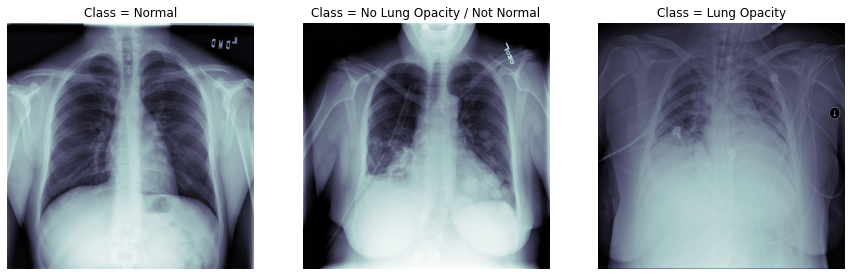

In [43]:
print('Checking sample for different classes')
sample1 = train_class.loc[train_class['class'] == 'Normal'].iloc[0]
sample2 = train_class.loc[train_class['class'] == 'No Lung Opacity / Not Normal'].iloc[0]
sample3 = train_class.loc[train_class['class'] == 'Lung Opacity'].iloc[1]
ds1 = dcm.dcmread(sample1['path'])
ds2 = dcm.dcmread(sample2['path'])
ds3 = dcm.dcmread(sample3['path'])

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))
ax1.imshow(ds1.pixel_array, cmap = plt.cm.bone)
ax1.set_title('Class = Normal')
ax1.axis('off')
ax2.imshow(ds2.pixel_array, cmap = plt.cm.bone)
ax2.set_title('Class = No Lung Opacity / Not Normal')
ax2.axis('off')
ax3.imshow(ds3.pixel_array, cmap = plt.cm.bone)
ax3.set_title('Class = Lung Opacity')
ax3.axis('off')
plt.show()

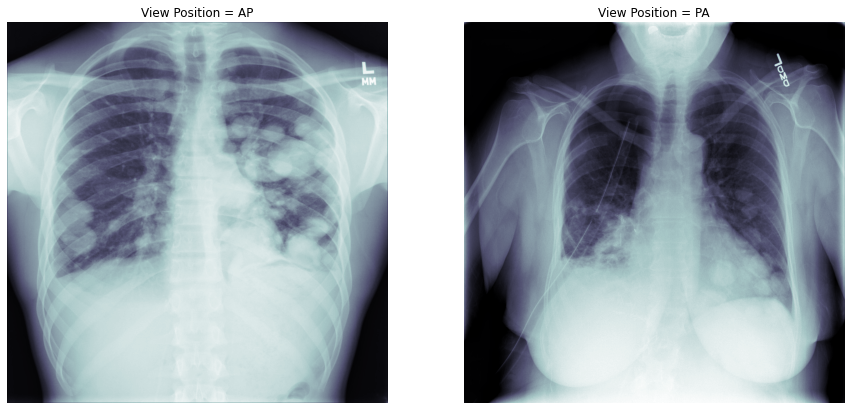

In [44]:
sample4 = train_class.loc[(train_class['ViewPosition'] == 'AP')].iloc[0]
sample5 = train_class.loc[(train_class['ViewPosition'] == 'PA')].iloc[0]
ds4 = dcm.dcmread(sample4['path'])
ds5 = dcm.dcmread(sample5['path'])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15, 8))
ax1.imshow(ds4.pixel_array, cmap = plt.cm.bone)
ax1.set_title('View Position = AP')
ax1.axis('off')
ax2.imshow(ds5.pixel_array, cmap = plt.cm.bone)
ax2.set_title('View Position = PA')
ax2.axis('off')
plt.show()

In [45]:
# Helper function to plot the dicom images
def plot_dicom_images(data, df, img_path):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3, 3, figsize = (16, 18))
    for i, row in enumerate(img_data):
        image = row['patientId'] + '.dcm'
        path = os.path.join(img_path, image)
        data = dcm.read_file(path)
        rows = df[df['patientId'] == row['patientId']]
        age = rows.PatientAge.unique().tolist()[0]
        sex = data.PatientSex
        part = data.BodyPartExamined
        vp = data.ViewPosition
        modality = data.Modality
        data_img = dcm.dcmread(path)
        ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                              .format(row['patientId'], age, sex, part, 
                                      vp, modality, row['Target'], 
                                      row['class'], row['x'], 
                                      row['y'], row['width'],
                                      row['height']))
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                      width = row['width'], height = row['height'], 
                      color = 'blue', alpha = 0.15)) 
    plt.show()

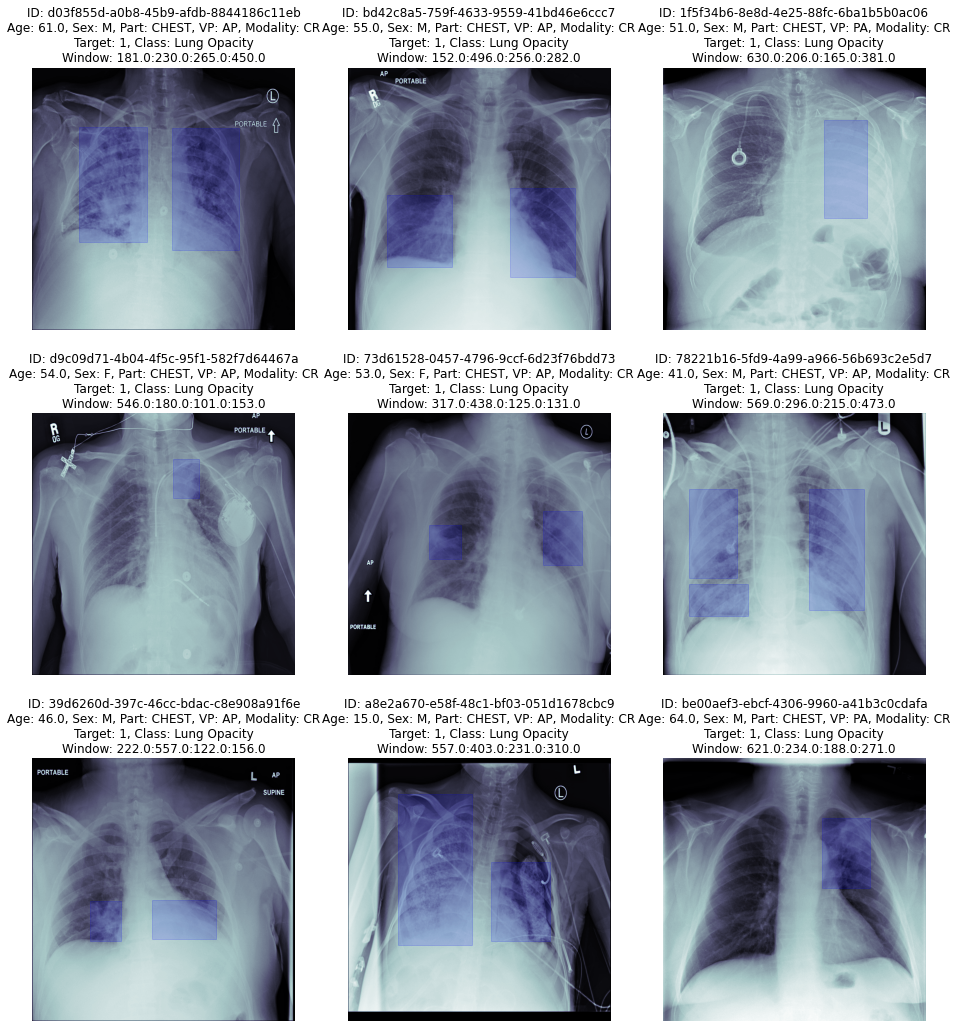

In [46]:
# this function is a part of custom module imported earlier (`eda`)
plot_dicom_images(data = train_class.loc[(train_class['Target'] == 1)].sample(9), 
                  df = train_class, img_path = TRAIN_IMAGES)

###  Image compression and It's Coordinates behaviour  ###

In [ ]:
### Image and bound box display, without compression and no change on bounding box coordinates ###

* No image compression                      
* No change on bounding box coordinates 

(1024, 1024)




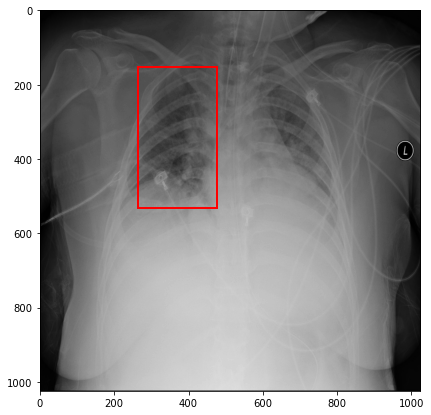

In [47]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.patches as patches



def overlay_show(train_class, number, classname, path):
    
    if(train_class.iloc[number]['class'] == classname):
        img_path = os.path.join(path, train_class.iloc[number]['patientId'])
        img = dcm.read_file(img_path+'.dcm')
        img_data = img.pixel_array
        print(img_data.shape)
        print("\n")
        x1 = train_class.iloc[number]['x']
        y1 = train_class.iloc[number]['y']
        width = train_class.iloc[number]['width']
        height = train_class.iloc[number]['height']
   
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(7, 7)
        ax.imshow(img_data, cmap = 'gray')

        x, y, width, height  = x1, y1, width, height
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        # Draw the bounding box on top of the image
        ax.add_patch(rect)
        plt.show()

        
path = 'C:\Janardhana_ArtificalIntelligence\Janardhana_Work_AI\Capstone_Project\Project_Statement_DataSet\stage_2_train_images'

# overlay display 
overlay_show(train_class, 4, "Lung Opacity", path)



In [ ]:
### Image and bound box display, with compression and no change on bounding box coordinates ###

* Only image compression                      
* No change on bounding box coordinates 
* pixel ratio will compression by the number.
  e.g pixel ratio 2 means compression is half

(512, 512)




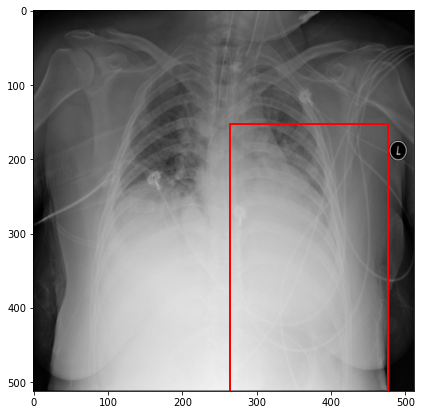

In [48]:

from skimage.transform import resize


def overlay_show_image_comp(train_class, number, classname, path, pixel_ratio):
    
    if(train_class.iloc[number]['class'] == classname):
        img_path = os.path.join(path, train_class.iloc[number]['patientId'])
        img = dcm.read_file(img_path+'.dcm')
        img_data = img.pixel_array
        width, height = img.pixel_array.shape
        width = width/pixel_ratio
        height = height/pixel_ratio
        
        dim = (width, height)
        img_data_new = resize(img_data, dim)
        print(img_data_new.shape)
        print("\n")
        x1 = train_class.iloc[number]['x']
        y1 = train_class.iloc[number]['y']
        width1 = train_class.iloc[number]['width']
        height1 = train_class.iloc[number]['height']
   
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(7,7)
        ax.imshow(img_data_new, cmap = 'gray')

        x, y, width, height  = x1, y1, width1, height1
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        # Draw the bounding box on top of the image
        ax.add_patch(rect)
        plt.show()



# overlay display with compressed image
overlay_show_image_comp(train_class, 4, "Lung Opacity", path, 2)

In [ ]:
### Image and bound box display, with compression and change on bounding box coordinates ###


* image compression                      
* Bounding box coordinates also compressed
* pixel ratio will compression by the number.
  e.g pixel ratio 2 means compression is half

(341, 341)




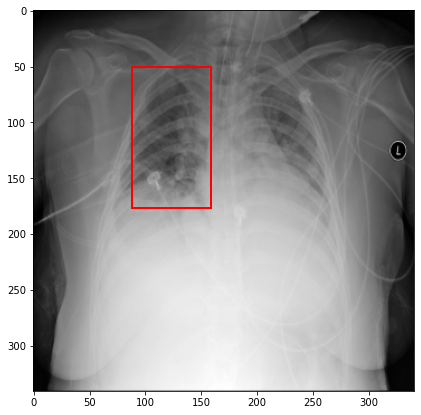

In [49]:
from skimage.transform import resize


def overlay_show_image_comp_change_box(train_class, number, classname, path, pixel_ratio):
    
    if(train_class.iloc[number]['class'] == classname):
        img_path = os.path.join(path, train_class.iloc[number]['patientId'])
        img = dcm.read_file(img_path+'.dcm')
        img_data = img.pixel_array
        width, height = img.pixel_array.shape
        width = width/pixel_ratio
        height = height/pixel_ratio
        
        dim = (width, height)
        img_data_new = resize(img_data, dim)
        print(img_data_new.shape)
        print("\n")
        x1 = train_class.iloc[number]['x']/pixel_ratio
        y1 = train_class.iloc[number]['y']/pixel_ratio
        width1= train_class.iloc[number]['width']/pixel_ratio
        height1 = train_class.iloc[number]['height']/pixel_ratio
   
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(7,7)
        ax.imshow(img_data_new, cmap = 'gray')

        x, y, width, height  = x1, y1, width1, height1
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        # Draw the bounding box on top of the image
        ax.add_patch(rect)
        plt.show()


        
        
#print(img_data.shape)

# overlay display 
overlay_show_image_comp_change_box(train_class, 4, "Lung Opacity", path, 3)

### CNN Model ###

In [50]:
## Just taking limited samples from the dataset
sample_trainigdata = train_class.groupby('class', group_keys=False).apply(lambda x: x.sample(2000))

In [51]:
## Checking the training data set with class distbution 
sample_trainigdata["class"].value_counts()
#sample_trainigdata["Target"].value_counts()

Lung Opacity                    2000
No Lung Opacity / Not Normal    2000
Normal                          2000
Name: class, dtype: int64

In [52]:
sample_trainigdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 21161 to 11582
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patientId        6000 non-null   object 
 1   x                2000 non-null   float64
 2   y                2000 non-null   float64
 3   width            2000 non-null   float64
 4   height           2000 non-null   float64
 5   Target           6000 non-null   int64  
 6   number_of_boxes  6000 non-null   int64  
 7   class            6000 non-null   object 
 8   path             6000 non-null   object 
 9   PatientSex       6000 non-null   object 
 10  PatientAge       6000 non-null   float64
 11  ViewPosition     6000 non-null   object 
dtypes: float64(5), int64(2), object(5)
memory usage: 609.4+ KB


In [53]:
## Pre Processing the image
from tensorflow.keras.applications.mobilenet import preprocess_input

images = []
#ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image, ADJUSTED_IMAGE_SIZE):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

DIR= 'C:\Janardhana_ArtificalIntelligence\Janardhana_Work_AI\Capstone_Project\Project_Statement_DataSet\stage_2_train_images'

## Read the imahge and resize the image
def populateImage(rowData, ADJUSTED_IMAGE_SIZE):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = DIR+'\{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img, ADJUSTED_IMAGE_SIZE))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

In [47]:
## Reading the images into numpy array
images,labels = populateImage(sample_trainigdata, 128)

In [48]:
images.shape , labels.shape
## The image is of 128*128 with 3 channels

((6000, 128, 128, 3), (6000,))

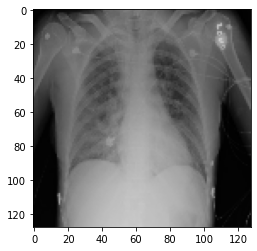

In [49]:
## Checking one of the converted image 
plt.imshow(images[100])

In [50]:
## check the unique labels
np.unique(labels),len(np.unique(labels))

(array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
       dtype='<U28'),
 3)

In [51]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
# define model
from tensorflow.keras import losses,optimizers
from tensorflow.keras.layers import Dense,  Activation, Flatten,Dropout,MaxPooling2D,BatchNormalization
import pandas as pd
import tensorflow 
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
import matplotlib.pyplot as plt
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from sklearn.model_selection import StratifiedKFold
%matplotlib inline
#Test Train Split
from sklearn.model_selection import train_test_split
#Feature Scaling library
from sklearn.preprocessing import StandardScaler
#import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense ,LeakyReLU
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [52]:
## encoding the labels
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y2 = enc.fit_transform(labels)

In [53]:
## splitting into train ,test and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

In [54]:
## FUnction to create a dataframe for results
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

In [55]:
## CNN Model without transfer learning , we start with 32 filters with 5,5 kernal and no padding , then 64 and 128 wiht drop layers in between 
## And softmax activaation as the last layer
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [56]:
# Model Summary
cnn = cnn_model(128,128,3,3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

In [59]:
## Training for 10 epocs with batch size of 10
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 10, 
                  validation_data = (X_val,y_val),
                  batch_size = 10)

Epoch 1/10
420/420 [==============================] - 601s 1s/step - loss: 1.1273 - accuracy: 0.3571 - val_loss: 1.1201 - val_accuracy: 0.3133
Epoch 2/10
420/420 [==============================] - 590s 1s/step - loss: 1.1170 - accuracy: 0.3917 - val_loss: 1.0643 - val_accuracy: 0.4056
Epoch 3/10
420/420 [==============================] - 555s 1s/step - loss: 1.0885 - accuracy: 0.4095 - val_loss: 1.0430 - val_accuracy: 0.4722
Epoch 4/10
420/420 [==============================] - 546s 1s/step - loss: 1.0724 - accuracy: 0.4314 - val_loss: 1.0542 - val_accuracy: 0.4089
Epoch 5/10
420/420 [==============================] - 572s 1s/step - loss: 1.0675 - accuracy: 0.4421 - val_loss: 1.0583 - val_accuracy: 0.4244
Epoch 6/10
420/420 [==============================] - 580s 1s/step - loss: 1.0556 - accuracy: 0.4548 - val_loss: 1.0230 - val_accuracy: 0.4922
Epoch 7/10
420/420 [==============================] - 589s 1s/step - loss: 1.0478 - accuracy: 0.4721 - val_loss: 1.0466 - val_accuracy: 0.4989

In [61]:
# cnn evaluation 

fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

29/29 [==============================] - 15s 532ms/step - loss: 1.0334 - accuracy: 0.4744
Test loss: 1.0333831310272217
Test accuracy: 0.4744444489479065


In [65]:
# classification report

from sklearn.metrics import classification_report

y_predict = cnn.predict(X_test)

y_predict = (y_predict > 0.4) 
y_predict = y_predict.astype(int)

print(classification_report(y_test, y_predict))


29/29 [==============================] - 15s 519ms/step
              precision    recall  f1-score   support

           0       0.49      0.74      0.59       297
           1       0.00      0.00      0.00       285
           2       0.67      0.23      0.34       318

   micro avg       0.52      0.33      0.40       900
   macro avg       0.38      0.32      0.31       900
weighted avg       0.40      0.33      0.31       900
 samples avg       0.33      0.33      0.33       900



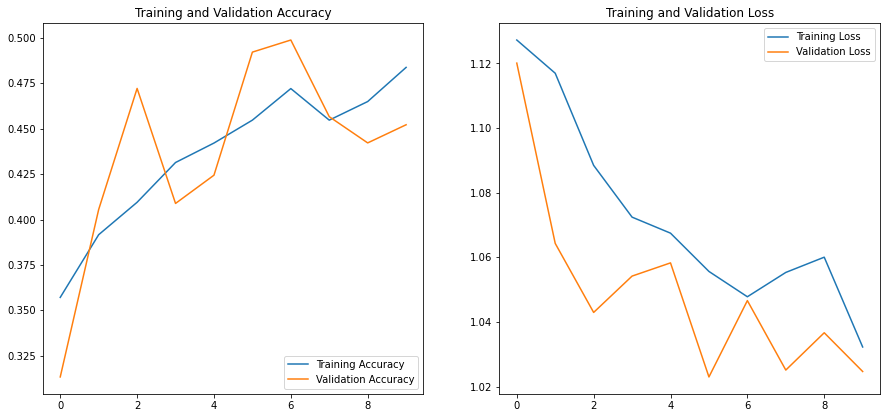

In [76]:
## PLottting the accuracy vs loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#The training and Validation loss is almost same, but for the training and validation accuracy chart, 
#the validation accuracy falls down in the later epochs, this could be because we have only taken 200 images for processing.

In [77]:
resultDF = createResultDf("CNN",acc[-1],fcl_accuracy)

29/29 [==============================] - 18s 614ms/step


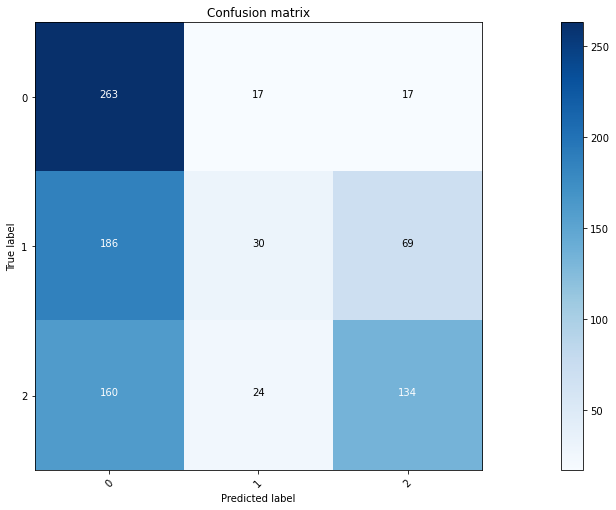

In [79]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

#Class 0 ,1 and 2
#Class 0 is Lung Opacity
#Class 1 is No Lung Opacity/Normal, the model has predicted mostly wrong in this case to the Target 0. Type 2 error
#Class 2 is Normal

In [80]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

29/29 [==============================] - 18s 606ms/step


,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN,0.48381,0.474444,0.422535,0.105263,0.168539,285


### Kfold cross validation on CNN ####

In [ ]:
#### Cross validation ####

* Kfold cross validation                    
* number of splits 5. 
* number of epochs 2.
* Because of computation time in local environment, we took splits as 5 and epochs as 2


In [81]:
#### Cross validation ####
import tensorflow
from tensorflow.keras.models import * 
from tensorflow.keras.layers import * 

from sklearn.model_selection import KFold, cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics


kfold = KFold(n_splits=5, shuffle=True, random_state=42) 

cross_val_y = []
cross_val_pred = []
fold =0
for train, test in kfold.split(images):
    fold=+1
    X_train = images[train]
    y_train = y2[train]
    X_test = images[test]
    y_test = y2[test]
        
    model = Sequential()
        
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
              activation ='relu', batch_input_shape = (None, 128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
              activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
        
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
              activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
              activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
              activation ='relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
              activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.4))
        
    model.add(GlobalMaxPooling2D())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = "softmax"))
        
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
        
    history = model.fit(X_train, 
                                y_train, 
                                epochs = 2, 
                                validation_data = (X_test,y_test),
                                batch_size = 10)
    y_pred = model.predict(X_test)
    
    cross_val_y.append(y_test)
    cross_val_pred.append(y_pred)
              
    score = np.sqrt(metrics.mean_squared_error(y_pred,y_test))
    print("K fold score: ", score)
    
    
cross_val_y = np.concatenate(cross_val_y)
cross_val_pred = np.concatenate(cross_val_pred)

score = np.sqrt(metrics.mean_squared_error(cross_val_pred, cross_val_y))
print("Final Kfold score: ", score)
              


Epoch 1/2
480/480 [==============================] - 700s 1s/step - loss: 1.5753 - accuracy: 0.3438 - val_loss: 1.0989 - val_accuracy: 0.3175
Epoch 2/2
38/38 [==============================] - 22s 583ms/step
K fold score:  0.4643507271115239
Epoch 1/2
480/480 [==============================] - 632s 1s/step - loss: 1.2965 - accuracy: 0.3456 - val_loss: 1.0929 - val_accuracy: 0.3808
Epoch 2/2
38/38 [==============================] - 19s 504ms/step
K fold score:  0.462302375092258
Epoch 1/2
480/480 [==============================] - 1312s 3s/step - loss: 1.7846 - accuracy: 0.3510 - val_loss: 1.0941 - val_accuracy: 0.3450
Epoch 2/2
38/38 [==============================] - 8s 214ms/step
K fold score:  0.4640592708957147
Epoch 1/2
480/480 [==============================] - 263s 546ms/step - loss: 1.7260 - accuracy: 0.3417 - val_loss: 1.0953 - val_accuracy: 0.3617
Epoch 2/2
38/38 [==============================] - 8s 209ms/step
K fold score:  0.46874389793618826
Epoch 1/2
480/480 [===========

###  Hyper parameters on CNN sequential model ###

In [ ]:
##### We can try below strategies to see if it enhances the model performance

- optimizer changd Adagrad optimizer
- loss is decreasing for each epoch and increasing acuuracy
- image pixel try from 128 
- increase epoch 5  and batch size 64. Because of computation time, We took epoch 5 instead of large number(e.g 30).
- sample size from 2000, Due to computation time in local environment we took sample size as 2000

In [131]:

## Just taking limited samples from the dataset
sample_tr_data = train_class.groupby('class', group_keys=False).apply(lambda x: x.sample(2000))
print("sample data is completed")

sample data is completed


In [132]:
# head and shape of sample
print(sample_tr_data.head())
print(sample_tr_data.shape)

                                  patientId      x      y  width  height  \
5377   4668a90c-d352-47d0-a3ac-a54aa8ce053b  134.0  272.0  193.0   200.0   
2941   35147425-e8f1-494b-8cce-74252c0578d6  194.0  445.0  230.0   216.0   
12714  810b8ef8-f65f-4f24-9798-aa13ed4fc828  655.0  410.0  269.0   512.0   
29265  0fda72a2-f383-4f69-af8e-e16a0fbac621  695.0  457.0  215.0   220.0   
21438  c348479b-d4d4-4cee-8113-763b803820fb  203.0  155.0  237.0   413.0   

       Target  number_of_boxes         class  \
5377        1                3  Lung Opacity   
2941        1                2  Lung Opacity   
12714       1                2  Lung Opacity   
29265       1                2  Lung Opacity   
21438       1                2  Lung Opacity   

                                                    path PatientSex  \
5377   C:\Janardhana_ArtificalIntelligence\Janardhana...          F   
2941   C:\Janardhana_ArtificalIntelligence\Janardhana...          F   
12714  C:\Janardhana_ArtificalIntelligenc

In [133]:
images = []
#ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
#originalImage = []

## Reading the images_data into numpy array
images_data,labels_data = populateImage(sample_tr_data, 128)

In [134]:
# split train, test and validation data

## encoding the labels
from sklearn.preprocessing import LabelBinarizer

enc = LabelBinarizer()
y2 = enc.fit_transform(labels_data)

X_train, X_test, y_train, y_test = train_test_split(images_data, y2, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)
print("split is completed")


split is completed


In [135]:
# Building CNN Sequential model

def cnn_model_1(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))
    
  model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.5))

  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.6))
  model.add(Dense(num_classes, activation = "softmax"))

  #optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.01)

  #optimizer = RMSprop(lr=0.01, rho=0.9, epsilon=0.01, decay=0.01)

  optimizer=Adagrad(lr=1e-4, epsilon=1e-08, decay=0.01)

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model


In [136]:
# model summary 

from tensorflow.keras.optimizers import Adagrad

ADJUSTED_IMAGE_SIZE = 128

cnn1 = cnn_model_1(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 128, 128, 32)      2432      
                                                                 
 conv2d_53 (Conv2D)          (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_54 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_55 (Conv2D)          (None, 64, 64, 64)        36928     
                                                     

In [139]:
# fit model, epochs 5 and batch size 64
history = cnn1.fit(X_train, 
                   y_train, 
                  epochs = 5, 
                  validation_data = (X_val, y_val),
                  batch_size = 64)

Epoch 1/5
66/66 [==============================] - 503s 8s/step - loss: 3.3031 - accuracy: 0.3340 - val_loss: 1.1049 - val_accuracy: 0.3578
Epoch 2/5
66/66 [==============================] - 499s 8s/step - loss: 2.4466 - accuracy: 0.3374 - val_loss: 1.1027 - val_accuracy: 0.3533
Epoch 3/5
66/66 [==============================] - 492s 7s/step - loss: 2.2108 - accuracy: 0.3343 - val_loss: 1.1002 - val_accuracy: 0.3656
Epoch 4/5
66/66 [==============================] - 495s 8s/step - loss: 2.0028 - accuracy: 0.3407 - val_loss: 1.0996 - val_accuracy: 0.3700
Epoch 5/5
66/66 [==============================] - 483s 7s/step - loss: 1.9128 - accuracy: 0.3445 - val_loss: 1.0986 - val_accuracy: 0.3644


In [140]:
# evaluation

fcl_loss, fcl_accuracy = cnn1.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

29/29 [==============================] - 15s 501ms/step - loss: 1.1015 - accuracy: 0.3500
Test loss: 1.1015208959579468
Test accuracy: 0.3499999940395355


In [141]:

# classification report

from sklearn.metrics import classification_report

y_predict = cnn1.predict(X_test)

y_predict = (y_predict > 0.4) 
y_predict = y_predict.astype(int)

print(classification_report(y_test, y_predict))


29/29 [==============================] - 15s 501ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       297
           1       0.00      0.00      0.00       285
           2       0.26      0.02      0.03       318

   micro avg       0.25      0.01      0.01       900
   macro avg       0.09      0.01      0.01       900
weighted avg       0.09      0.01      0.01       900
 samples avg       0.01      0.01      0.01       900



29/29 [==============================] - 15s 503ms/step


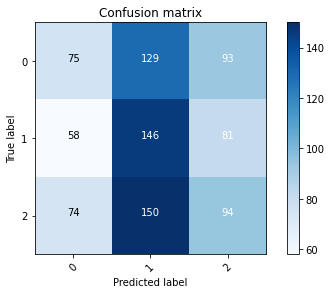

In [142]:
# confusion matrix

# Predict the values from the validation dataset
Y_pred = cnn1.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))


### We can try below strategies to see if it enhances the model performance ###

- optimizer changed Adam optimizer
- loss is decreasing for each epoch and increasing acuuracy
- image pixel try from 128 
- epoch 5 and batch size 64. Because of computation time in local environment we took epochs 5 and batchsize 64 only.
- sample size from 2000

In [144]:
# Building CNN Sequential model 

def cnn_model_1(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))
    
  model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.5))

  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.6))
  model.add(Dense(num_classes, activation = "softmax"))

  #optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.01)

  #optimizer = RMSprop(lr=0.01, rho=0.9, epsilon=0.01, decay=0.01)

  optimizer= Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [145]:
# model summary

from tensorflow.keras.optimizers import Adagrad

ADJUSTED_IMAGE_SIZE = 128

cnn2 = cnn_model_1(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 128, 128, 32)      2432      
                                                                 
 conv2d_61 (Conv2D)          (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_39 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_62 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_63 (Conv2D)          (None, 64, 64, 64)        36928     
                                                     

In [146]:
# fit the model, epochs 5 and batch size 64

history = cnn2.fit(X_train, 
                   y_train, 
                  epochs = 5, 
                  validation_data = (X_val, y_val),
                  batch_size = 64)

Epoch 1/5
66/66 [==============================] - 516s 8s/step - loss: 3.2215 - accuracy: 0.3314 - val_loss: 1.0979 - val_accuracy: 0.3656
Epoch 2/5
66/66 [==============================] - 492s 7s/step - loss: 1.0942 - accuracy: 0.3631 - val_loss: 1.0953 - val_accuracy: 0.3433
Epoch 3/5
66/66 [==============================] - 489s 7s/step - loss: 1.0754 - accuracy: 0.4112 - val_loss: 1.0717 - val_accuracy: 0.4133
Epoch 4/5
66/66 [==============================] - 786s 12s/step - loss: 1.0527 - accuracy: 0.4412 - val_loss: 1.0820 - val_accuracy: 0.3644
Epoch 5/5
66/66 [==============================] - 1333s 20s/step - loss: 1.0400 - accuracy: 0.4579 - val_loss: 1.0726 - val_accuracy: 0.3722


In [147]:
# evaluation

fcl_loss, fcl_accuracy = cnn2.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)


29/29 [==============================] - 42s 1s/step - loss: 1.0769 - accuracy: 0.3744
Test loss: 1.0768531560897827
Test accuracy: 0.37444445490837097


In [148]:
# classification report

from sklearn.metrics import classification_report

y_predict = cnn2.predict(X_test)

y_predict = (y_predict > 0.4) 
y_predict = y_predict.astype(int)

print(classification_report(y_test, y_predict))


29/29 [==============================] - 42s 1s/step
              precision    recall  f1-score   support

           0       0.47      0.85      0.60       297
           1       0.00      0.00      0.00       285
           2       0.50      0.00      0.01       318

   micro avg       0.47      0.28      0.35       900
   macro avg       0.32      0.28      0.20       900
weighted avg       0.33      0.28      0.20       900
 samples avg       0.28      0.28      0.28       900



29/29 [==============================] - 42s 1s/step


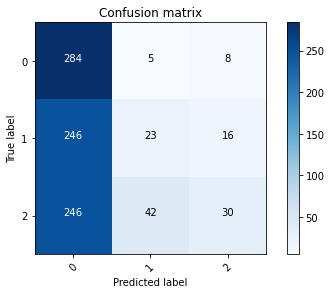

In [149]:

# Predict the values from the validation dataset
Y_pred = cnn2.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))


### CNN with Tranfer learning using VGG16 ###
- VGG16 model
- Adam optimizer
- epochs 5 because of computation time in local environment we took epochs 5 only.
- sample size from 2000
- VGG16 accuracy is better than previous models.

In [115]:
## Creating a Copy, it is for backup or future use

X_train1 = X_train.copy()
X_val1 = X_val.copy()
X_test1 = X_test.copy()

In [116]:
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [117]:
# creating VGG16 model 

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)

In [118]:
## Adding two hidden later and one softmax layer as an output layer
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')

# passing VGG16 model to sequential
cnn_VGG16_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [119]:
# VGG16 compile and fit the model 

from tensorflow.keras.callbacks import EarlyStopping

cnn_VGG16_model.compile(
    optimizer='Adam',
    loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Early stopping whe validation accuracy does not change for 4 iteration 
es = EarlyStopping(monitor='val_accuracy', mode='auto', patience=4,  restore_best_weights=True)

#Trainign the model
history = cnn_VGG16_model.fit(train_ds, y_train, epochs=5, validation_data=(train_val_df,y_val) ,callbacks=es)

Epoch 1/5
132/132 [==============================] - 298s 2s/step - loss: 0.7975 - accuracy: 0.5824 - val_loss: 0.5316 - val_accuracy: 0.6033
Epoch 2/5
132/132 [==============================] - 273s 2s/step - loss: 0.4637 - accuracy: 0.6729 - val_loss: 0.5245 - val_accuracy: 0.5889
Epoch 3/5
132/132 [==============================] - 287s 2s/step - loss: 0.4069 - accuracy: 0.7126 - val_loss: 0.6673 - val_accuracy: 0.6489
Epoch 4/5
132/132 [==============================] - 274s 2s/step - loss: 0.3555 - accuracy: 0.7586 - val_loss: 0.6158 - val_accuracy: 0.6344
Epoch 5/5
132/132 [==============================] - 279s 2s/step - loss: 0.2914 - accuracy: 0.8090 - val_loss: 0.6047 - val_accuracy: 0.6489


In [120]:
# evaluation 

test_ds = preprocess_input(X_test1) 
fcl_loss, fcl_accuracy = cnn_VGG16_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

#

29/29 [==============================] - 50s 2s/step - loss: 0.5657 - accuracy: 0.6556
Test loss: 0.5656861662864685
Test accuracy: 0.6555555462837219


In [126]:
# classification report

from sklearn.metrics import classification_report

y_predict = cnn_VGG16_model.predict(X_test)

y_predict = (y_predict > 0.4) 
y_predict = y_predict.astype(int)

print(classification_report(y_test, y_predict))


29/29 [==============================] - 49s 2s/step
              precision    recall  f1-score   support

           0       0.66      0.74      0.70       297
           1       0.48      0.41      0.44       285
           2       0.73      0.80      0.76       318

   micro avg       0.64      0.66      0.65       900
   macro avg       0.62      0.65      0.63       900
weighted avg       0.63      0.66      0.64       900
 samples avg       0.64      0.66      0.64       900



29/29 [==============================] - 48s 2s/step


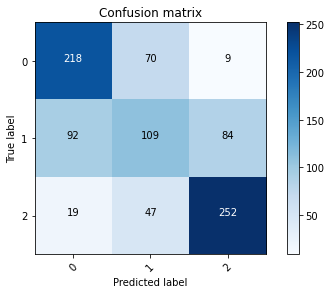

In [127]:
# Predict the values from the validation dataset
Y_pred = cnn_VGG16_model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

### Pretrained model - DenseNet121 ### 

In [ ]:
### DennseNet121 pretrained X-ray model ####

- parsed to only two categories
- this model target supports only size of 2 array, one hot encoding
- epcohs and batchsize, mulitple combinations not tried. Computation taking more time.

In [54]:
## Just taking limited samples from the dataset
sample_tr_data = train_class.groupby('class', group_keys=False).apply(lambda x: x.sample(2000))


In [55]:
# popluate images 
# class label classifying as Normal or Lung Opacity. No Lung Opacity/Not Normal changed as Normal

DIR= 'C:\Janardhana_ArtificalIntelligence\Janardhana_Work_AI\Capstone_Project\Project_Statement_DataSet\stage_2_train_images'

## Read the imahge and resize the image
def populateImage_parsing(rowData, ADJUSTED_IMAGE_SIZE):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        if(classlabel == "No Lung Opacity / Not Normal"):
            classlabel = 'Normal'
        dcm_file = DIR+'\{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img, ADJUSTED_IMAGE_SIZE))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels


In [56]:
images = []
#ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
#originalImage = []

## Reading the images_data into numpy array
images_data,labels_data = populateImage_parsing(sample_tr_data, 224)


### creating dataframe 

data = pd.DataFrame([imageList, labels_data])
data = data.transpose() 
data.columns=['Images','Category']
data.head()


,Images,Category
0,"[[[12, 12, 12], [10, 10, 10], [11, 11, 11], [1...",Lung Opacity
1,"[[[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], ...",Lung Opacity
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Lung Opacity
3,"[[[10, 10, 10], [8, 8, 8], [10, 10, 10], [8, 8...",Lung Opacity
4,"[[[7, 7, 7], [7, 7, 7], [7, 7, 7], [7, 7, 7], ...",Lung Opacity


In [57]:
## encoding the labels
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

image_metadata = data['Images']
#y2 = data['Category']

# one hot encoding and transform data Category
ohe = OneHotEncoder()
y2 = ohe.fit_transform(data.Category.values.reshape(-1,1)).toarray()

# split the train, test and validation data
X_train, X_test, y_train, y_test = train_test_split(images_data, y2, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)



In [58]:
# Pretrained DenseNet121 model

# import library
import tensorflow 
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import backend as K

# Create the base pre-trained model.
base_model = DenseNet121(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer.
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add two fully-connected layers.
x = Dense(128, activation='relu')(x)
activations_layer = Dense(8, activation='relu')(x)

# Add a logistic layer for the output.
predictions = Dense(2, activation='softmax')(activations_layer)

# Define the model we will train.
model = Model(inputs=base_model.input, outputs=predictions)



In [62]:
# compile the model and fit the model

# convolutional DenseNet121 layers.
for layer in base_model.layers:
    layer.trainable = False
    
# Compile the model with the loss, optimizer and custom metric functions.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#,
#    weighted_metrics=[f1_score])

batch_size = 16
#train_images = np.asarray(X_train['img_arr'].tolist())
X_train_arr = np.asarray(X_train.tolist())
X_val_arr = np.asarray(X_val.tolist())
# Train the model on the train data for for 10 epochs with a batch size of 16.
model.fit(X_train_arr, y_train, batch_size=16, validation_data = (X_val_arr, y_val ), epochs=5, verbose=1)



Epoch 1/5
263/263 [==============================] - 276s 1s/step - loss: 0.6389 - accuracy: 0.6633 - val_loss: 0.6284 - val_accuracy: 0.6789
Epoch 2/5
263/263 [==============================] - 259s 987ms/step - loss: 0.6388 - accuracy: 0.6633 - val_loss: 0.6284 - val_accuracy: 0.6789
Epoch 3/5
263/263 [==============================] - 264s 1s/step - loss: 0.6388 - accuracy: 0.6633 - val_loss: 0.6283 - val_accuracy: 0.6789
Epoch 4/5
263/263 [==============================] - 269s 1s/step - loss: 0.6388 - accuracy: 0.6633 - val_loss: 0.6283 - val_accuracy: 0.6789
Epoch 5/5
263/263 [==============================] - 265s 1s/step - loss: 0.6389 - accuracy: 0.6633 - val_loss: 0.6283 - val_accuracy: 0.6789


In [72]:
# evaluation 

X_test_arr = np.asarray(X_test.tolist())

fcl_loss, fcl_accuracy = model.evaluate(X_test_arr, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

29/29 [==============================] - 51s 2s/step - loss: 0.6343 - accuracy: 0.6700
Test loss: 0.634279191493988
Test accuracy: 0.6700000166893005


In [68]:
# classification report

from sklearn.metrics import classification_report

X_test_arr = np.asarray(X_test.tolist())

y_predict = model.predict(X_test_arr)

y_predict = (y_predict > 0.4) 
y_predict = y_predict.astype(int)
y_test = y_test.astype(int)

print(classification_report(y_test, y_predict))


29/29 [==============================] - 47s 2s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       297
           1       0.67      1.00      0.80       603

   micro avg       0.67      0.67      0.67       900
   macro avg       0.34      0.50      0.40       900
weighted avg       0.45      0.67      0.54       900
 samples avg       0.67      0.67      0.67       900



29/29 [==============================] - 49s 2s/step


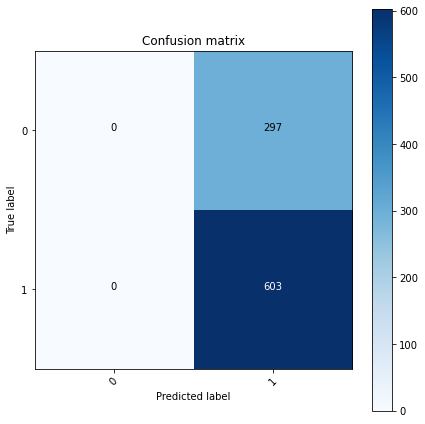

In [73]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(6,6)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test_arr)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))


In [ ]:
###  VGG19 Medical Research on Fundus Images (Diabetic Retinopathy)  ###

In [ ]:
###  VGG19 Medical Research on Fundus Images (Diabetic Retinopathy)  ###

Diabetic Retinopathy Image classification:

Diabetic retinopathy is a serious and widespread disease worldwide. Recently, the World Health Organization (WHO)
has reported that diabetes will become the seventh highest death causing disease in the world by 2030. 
In this context, it is a big challenge to save the lives of patients affected by diabetes. 

Diabetic retinopathy is a common disease that exists in diabetic patients. In diabetic retinopathy, some lesions
are produced in the eyes, which become a cause of non-reversible blindness with the passage of time.
These types of lesions include abnormal retinal blood vessels, microaneurysm, cotton wool spots,
exudates, and hemorrhages. 


1. Automated medical image analysis is an emerging field of research that identifies the
   disease with the help of Computer Vision technology. 
    
2. Diabetic retinopathy is a retinal disease that is diagnosed in diabetic patients.

3. Deep neural networks classify retinopathy by using fundus images of patients.

4. fundus images nothing reflecting light to make two image of three dimensional retina.

5. Retina image classification done by using Gausian Mixture model, Visual Geometry Group network 19, 
   singluar value decomposition and Principal Component Analysis and softmax

6. Gausian Mixture Model is used for region segmentation

7. VGG19 is used for high dimensional feature extraction

8. SVD is used for feature selection

9. PCA and softmax is used for fundus image classification


Feature Extraction and VGG19 Model:
    

In each layer of the CNNs, there is a new representation of the input image by progressively extracting meaningful information.
VGG-19 was applied to extract the meaningful information from the fundus images. 
The visualization discloses the categorized image format that makes the representation. 
To obtain a robust diabetic retinopathy system (DRS), the extraction process considers meaningful
features including the area of pixels, perimeter, minor axis length, major axis length as well as
circularity, which are helpful to identify blood vessel, exudates, hemorrhages, optical distance,
and microaneurysm areas


VGG19 DNN is a deep neural network with a multilayered operation. 
The VGGNet is based on the CNN model and is applied on the ImageNet dataset. VGG-19
is useful due to its simplicity as 3 × 3 convolutional layers are mounted on the top to increase with
depth level. To reduce the volume size, max pooling layers were used as a handler in VGG-19.
Two FC layers were used with 4096 neurons.

In the training phase, convolutional layers were used for the feature extraction and max pooling layers 
associated with some of the convolutional layers to reduce the feature dimensionality. 

In the first convolutional layer, 64 kernels (3 × 3 filter size) were 
applied for feature extraction from the input images. Fully connected layers were used to prepare the
feature vector. The acquired feature vector was further subjected to PCA and SVD for dimensionality
reduction and the feature selection of image data for better classification results. To reduce the highly
dimensional data using PCA and SVD is a significant task. PCA and SVD are more useful because
they are faster and numerically more stable than other reduction techniques. 

Finally, in the testing phase, 10-fold cross validation was applied to classify the DR images based on the softmax activation
technique. The performance of the proposed VGG-19 based system was compared with other feature
extraction architectures including AlexNet and SIFT. AlextNet is a multilayered feature extraction
architecture used in Convolution neural networks. The scale-invariant feature transform (SIFT) is a classical feature extraction
technique to detect the local features of the input image in the field of computer vision.


The softmax classifier was applied to classify the fundus images on the basis of its
features. The proposed classification was further trained to classify the fundus images into five
standard classes including non-DR, mild severe, moderate severe, severe, and PDR.




In [ ]:
###  RESNET50 Medical Research on Magnetic Resonance Imaging (MRI) (Brain Tumor )  ###

In [ ]:
###  RESNET50 Medical Research on Magnetic Resonance Imaging (MRI) (Brain Tumor )  ###


Brain Tumor Image Classification:
    
    
A brain tumor that may form in the skull is characterized as abnormal and unrestrained synapses. 
It puts pressure on the brain and harmfully affects the health of a human being. According to
the National Brain Tumor Foundation (NBTF) data, the brain tumor death rate has recently increased 
by nearly 200% in many countries. Early detection and classification of tumors are vital to
the research domain in biomedical imaging and, as a result, helps deliver treatment methods that increase 
the chances of patientsurvival. Magnetic resonance imaging (MRI) is the most popular imaging technique as it affords radiologists detailed information on
brain tumors. But, few factors like the quality of an MRI device and low image resolution may degrade the quality of MRI images.
Also, the detection of tumors in low-resolution images is challenging.

Super-resolution (SR) schemes overcome this problem by crafting a high-resolution (HR) image whose expanded, 
and enhanced details stem from adequate processing of low-resolution (LR) images. By augmenting the images’ resolution, 
MRI image becomes more apparent, which helps to classify the tumor correctly. 
Super-resolution techniques are classified in to three methods viz. interpolation, reconstruction, and learning-based methods.


Discrete cosine transform:
Discrete cosine tranform based is a novel fusion technique to fuse multiple images of MRI images. The best
quality patches of images are selected using this method and fused in the DCT domain. 
The quality of the output image increases by using a consistency verification procedure.

Convolution Networks:
The second contribution is the Convolution neural network used to super-resolve the low-resolution MRI image.

DCT-CNN SR-RESNET50:
    
Combining the DCT fusion, CNN SR, and ResNet50 (Residual Network 50) frameworks.        
DCT-CNN-ResNet50 architecture, the same design gives rise to the third contribution. 
Image extraction, Best quality patch selection and Fusion, Patch selection and super-resolution.


1. ResNet-50 is a convolutional neural network that is 50 layers deep.

2. Block have 3 layers, it will improve accuracy and lesser training time.

2. You can load a pre-trained version of the network trained on more than a million images from the ImageNet database.

3. The pre-trained network can classify images into 1000 object categories, such as a keyboard, mouse, pencil, and many animals. 
   As a result, the network has learned rich feature representations for a wide range of images


